In [2]:
import xarray as xr
import numpy as np
import glob
import pandas as pd
import pygmt
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator
from scipy.ndimage import gaussian_filter
#################################################
# --- CONFIGURATION ---
min_max_dep=[-5, 50] # depth in km
n_rtp=[121, 121, 201]
region=[-12, -2, 50, 55]
region_plot=[-11, -5, 51, 55.7]
folder = "/home/bmelo/bin/SeisBlast/1D_velocity/3D-model/"
profile_files = sorted(glob.glob(folder + "/*_vp.nc"))  # your .nc files

In [3]:
def extrapolate_bottom_constant(vp, z):
    """
    Fill NaNs in the bottom and top layers of vp (z, lat, lon) using the last valid value above
    and the first valid value below, respectively.
    """
    vp_filled = vp.copy()
    nz, ny, nx = vp.shape

    for j in range(ny):
        for i in range(nx):
            col = vp[:, j, i]
            valid = np.isfinite(col)
            if np.any(valid):
                # Fill bottom layers
                last_idx = np.where(valid)[0].max()
                last_val = col[last_idx]
                col[last_idx+1:] = last_val
                
                # Fill top layers
                first_idx = np.where(valid)[0].min()
                first_val = col[first_idx]
                col[:first_idx] = first_val

                vp_filled[:, j, i] = col

    return vp_filled

In [4]:
print("Creating 3D grid...")
# --- GATHER ALL PROFILE POINTS ---
all_points = []
all_values = []

for f in profile_files:
    ds = xr.open_dataset(f)

    lon = ds["lon"].values  # shape: (x,)
    lat = ds["lat"].values  # shape: (x,)
    z = ds["z"].values      # shape: (z,)
    vp = ds["vp"].values    # shape: (z, x)
   # --- Filter out negative depths ---
    valid_idx = z >= 0
    z = z[valid_idx]
    vp = vp[valid_idx, :]       # apply same filter to vp grid

    # Build 2D arrays for each coordinate (broadcast to match vp)
    lon2d, z2d = np.meshgrid(lon, z)  # shape: (z, x)
    lat2d, _   = np.meshgrid(lat, z)  # shape: (z, x)

    # Stack into (N, 3) coordinates and flatten vp values
    all_points.append(np.column_stack([z2d.ravel(), lat2d.ravel(), lon2d.ravel()]))  # (z, lat, lon)
    all_values.append(vp.ravel())

# --- COMBINE ALL PROFILES ---
points = np.vstack(all_points)         # shape: (N_points, 3)
values = np.concatenate(all_values)    # shape: (N_points,)

# --- DEFINE TARGET GRID ---
lon_min, lon_max = region[0], region[1]
lat_min, lat_max = region[2], region[3]
z_min, z_max = min_max_dep

Ngrid = n_rtp
lon_grid = np.linspace(lon_min, lon_max, Ngrid[0])
lat_grid = np.linspace(lat_min, lat_max, Ngrid[1])
z_grid   = np.linspace(z_min, z_max, Ngrid[2])

# Create 3D meshgrid in z-lat-lon order
Z, LAT, LON = np.meshgrid(z_grid, lat_grid, lon_grid, indexing="ij")  # shape: (z, lat, lon)
interp_targets = np.column_stack([Z.ravel(), LAT.ravel(), LON.ravel()])  # shape: (N_gridpoints, 3)


Creating 3D grid...


In [5]:
# --- RBF INTERPOLATION ---
print("Interpolating with RBF...")
rbf = RBFInterpolator(
    points, values,
    kernel="linear",     # or "thin_plate_spline", "multiquadric"
    #epsilon=5.0,
    neighbors=40,         # adjust for performance vs. accuracy
    smoothing=0.5              # helps with robustness
)

vp_3d = rbf(interp_targets).reshape(Z.shape)
# Fill NaNs using nearest-neighbor extrapolation
vp_filled = extrapolate_bottom_constant(vp_3d, z)
# Apply a 3D Gaussian filter (in-place or on a copy)
vp_smooth = gaussian_filter(vp_filled, sigma=(2, 2, 2))  # (z, lat, lon)

Interpolating with RBF...


In [6]:
# --- SAVE TO NETCDF ---
ds_3d = xr.Dataset(
    {"vp": (("z", "lat", "lon"), vp_smooth)},
    coords={"z": z_grid, "lat": lat_grid, "lon": lon_grid},
    attrs={"description": "3D Vp model (RBF interpolated and smoothed)"}
)
ds_3d.to_netcdf(folder + "vp_3d_rbf.nc")
print("Saved 3D velocity model to vp_3d_rbf.nc.")

Saved 3D velocity model to vp_3d_rbf.nc.


In [7]:
print("Creating grid with land mask...")
ds = ds_3d  # adjust if needed
vp = ds["vp"].values    # (z, lat, lon)
lat = ds["lat"].values
lon = ds["lon"].values
z   = ds["z"].values

# --- Create 2D meshgrid of lat/lon for land mask ---
LON, LAT = np.meshgrid(lon, lat, indexing="xy")  # shape: (lat, lon)

# --- Use PyGMT to create land mask ---
# Create a dummy grid
grid = xr.Dataset(
    {"z": (("lat", "lon"), np.zeros_like(LON))},
    coords={"lat": lat, "lon": lon}
)
# Generate a mask: 1 for land, NaN for ocean
land_mask = pygmt.grdlandmask(
    region=[lon.min(), lon.max(), lat.min(), lat.max()],
    spacing=[lon[1] - lon[0], lat[1] - lat[0]],
    maskvalues=[0, np.nan, np.nan, np.nan, np.nan],
    resolution="i",
    registration="gridline"
)
land_mask_bool = np.isnan(land_mask.data)

# Broadcast the 2D land mask across the depth dimension
land_mask_3d = np.broadcast_to(land_mask_bool, vp.shape)

# Apply mask: keep only land values
vp_land = np.where(land_mask_3d, vp, np.nan)

# --- Save masked model if desired ---
ds_land = xr.Dataset(
    {"vp": (("z", "lat", "lon"), vp_land)},
    coords={"z": z, "lat": lat, "lon": lon},
    attrs={"description": "3D Vp model (land-masked)"}
)

Creating grid with land mask...


Calculate and plot 1D velocity average...


/tmp/ipykernel_2296784/2050907958.py:21: RuntimeWarning: Mean of empty slice
  vp_2d_avg = np.nanmean(vp_2d, axis=1)  # Average over horizontal axis


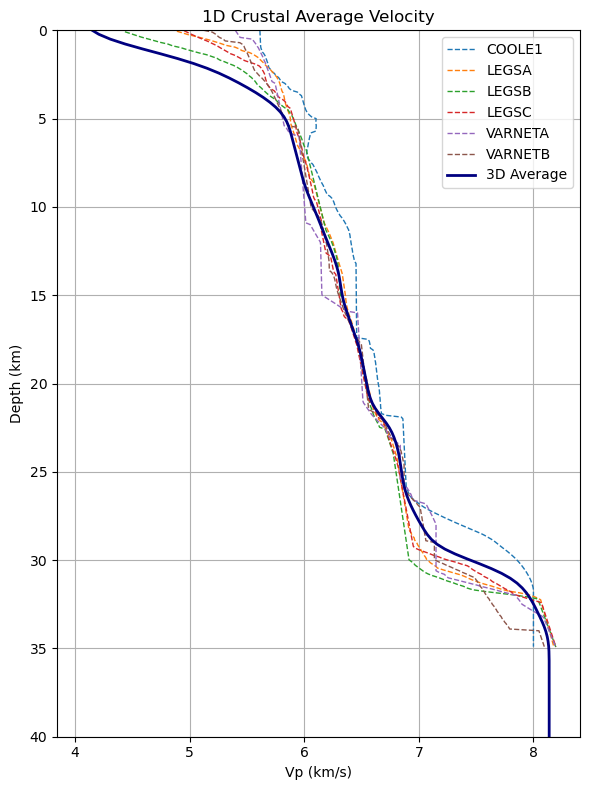

<Figure size 640x480 with 0 Axes>

In [8]:
print("Calculate and plot 1D velocity average...")
#1D velocity average
ds = ds_land  # adjust if needed
vp = ds["vp"].values    # (z, lat, lon)
lat = ds["lat"].values
lon = ds["lon"].values
z   = ds["z"].values
vp_1d = np.nanmean(vp, axis=(1, 2))  # shape: (z,)

# --- Compute velocity averages for each 2D profile ---
profile_averages = []
for f in profile_files:
    ds_2d = xr.open_dataset(f)
    tag=f.split("/")[-1].split("_")[0]  # Extract tag from filename
    #print(f"Processing profile {tag}...")
    z_2d = ds_2d["z"].values
    vp_2d = ds_2d["vp"].values  # shape: (z, x)
    valid_idx = z_2d >= 0  # Filter out negative depths
    z_2d = z_2d[valid_idx]
    vp_2d = vp_2d[valid_idx, :]
    vp_2d_avg = np.nanmean(vp_2d, axis=1)  # Average over horizontal axis
    profile_averages.append((z_2d, vp_2d_avg, tag))

# --- Plot the result ---
plt.figure(figsize=(6, 8))
for i, (z_2d, vp_2d_avg, tag) in enumerate(profile_averages):
    plt.plot(vp_2d_avg, z_2d, linestyle='--' ,lw=1, label=tag)
plt.plot(vp_1d, z, color='navy', lw=2, label="3D Average")
plt.gca().invert_yaxis()
plt.xlabel("Vp (km/s)")
plt.ylabel("Depth (km)")
plt.ylim(40,0)
plt.grid(True)
plt.title("1D Crustal Average Velocity")
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig(folder + "1D_crustal_average_velocity.png", dpi=300)

In [9]:
print("Saving 1D velocity model to ASCII file...")
Ngrid = n_rtp
# Create custom ASCII file in the format lon, lat, dep, velocity
with open(folder + "vp_1d_full.txt", "w") as f:
    for k in range(Ngrid[2]):
        for j in range(Ngrid[1]):
            for i in range(Ngrid[0]):
                if not np.isnan(vp_1d[k]):  # Only include non-NaN values
                    f.write(f"{lon[i]} {lat[j]} {z[k]} {vp_1d[k]}\n")
                    
with open(folder + "vp_1d_simple.txt", "w") as f:
    for k in range(Ngrid[2]):
        if not np.isnan(vp_1d[k]):
            f.write(f"{z[k]} {vp_1d[k]}\n")

Saving 1D velocity model to ASCII file...


In [10]:
from geopy.distance import geodesic
# Target depth and tolerance
target_depth = 7.0  # km
depth_tol = 0.5     # km tolerance window
sample_spacing_km = 10.0

# Collect original Vp sample points at target depth ± tol
scatter_points = []

for path in profile_files:
    ds_2d = xr.open_dataset(path)
    lat = ds_2d["lat"].values
    lon = ds_2d["lon"].values
    z   = ds_2d["z"].values
    vp  = ds_2d["vp"].values  # shape (z, x)
    #print(max(z))

    # Find indices of depth levels close to target depth
    close_depths = np.where(np.abs(z - target_depth) <= depth_tol)[0]

    for zi in close_depths:
        last_sample_point = None
        for j in range(len(lon)):
            point = (lat[j], lon[j])
            if last_sample_point is None or geodesic(point, last_sample_point).km >= sample_spacing_km:
                scatter_points.append([lon[j], lat[j], vp[zi, j]])
                last_sample_point = point

# Convert to DataFrame
df_scatter = pd.DataFrame(scatter_points, columns=["lon", "lat", "vp"])

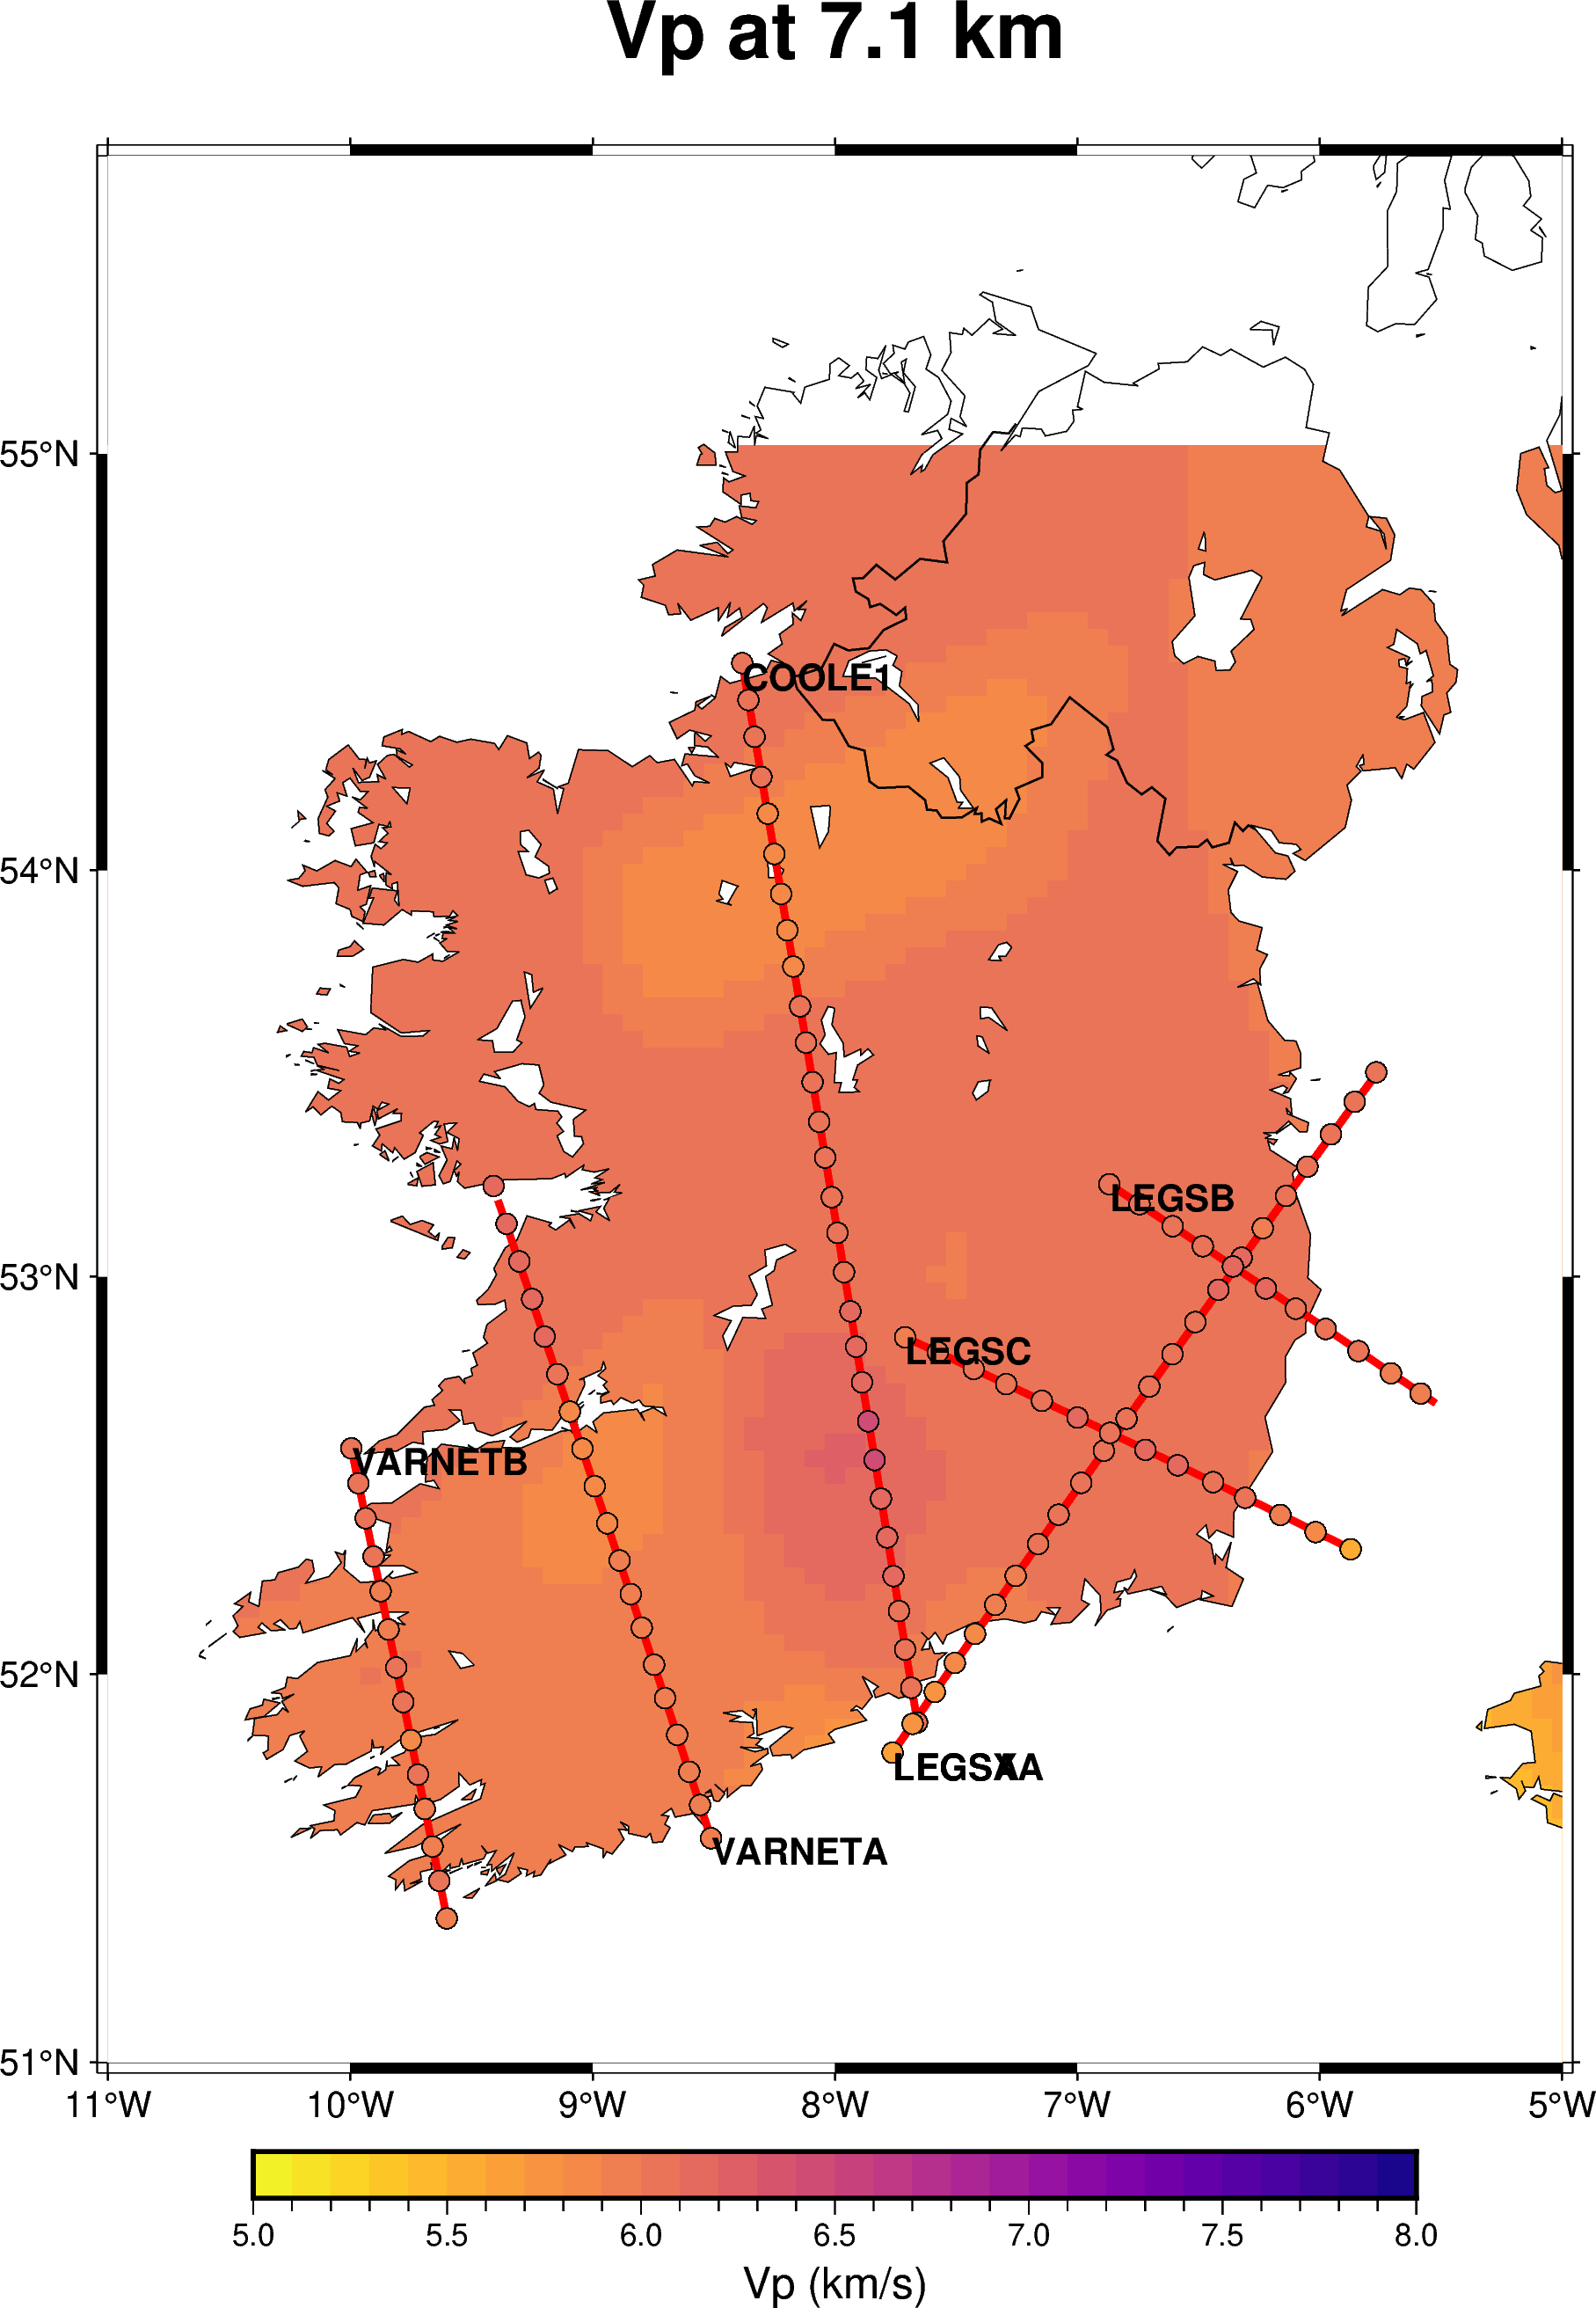

In [11]:
lines = pd.read_csv("/home/bmelo/bin/SeisBlast/1D_velocity/line_coords")

# --- Load the 3D NetCDF model ---
#ds = xr.open_dataset("/home/bmelo/bin/SeisBlast/1D_velocity/3D-model/vp_3d_rbf.nc")
ds = ds_3d
lat = ds["lat"].values
lon = ds["lon"].values
z   = ds["z"].values
#vp  = ds["vp"].values  # shape: (lat, lon, z)
vp = ds["vp"].transpose("z", "lat", "lon").values

depth_idx = (np.abs(z - target_depth)).argmin()
vp_slice = vp[depth_idx, :, :]  # (lat, lon)
# Confirm values exist
vp_slice = vp[depth_idx, :, :]  # shape: (lat, lon)

# --- Save temporary grid file ---
temp_grd = folder + "vp_slice.grd"
ds_slice = xr.Dataset(
    {"vp": (("lat", "lon"), vp_slice)},
    coords={"lat": lat, "lon": lon}
)
ds_slice.to_netcdf(temp_grd)

# --- Plot with PyGMT ---
fig = pygmt.Figure()
#region=[-11, -5, 51, 56]
fig.basemap(
    region=region_plot,
    projection="M14c",
    frame=["a", f"+tVp at {z[depth_idx]:.1f} km"]
)

pygmt.makecpt(cmap="plasma", series=[5, 8, 0.1], background=True, reverse=True)#, continuous=True)
fig.grdimage(grid=temp_grd, shading=False)

fig.coast(shorelines=True, borders="1/0.5p,black", resolution="i", water="white")
fig.colorbar(frame='af+lVp (km/s)')

# Plot each line
for _, row in lines.iterrows():
    fig.plot(x=[row["start_lon"], row["end_lon"]],
             y=[row["start_lat"], row["end_lat"]],
             pen="2p,red",
             label=row["tag"]) 

# Overlay Vp sample points at target depth
fig.plot(
    x=df_scatter["lon"],
    y=df_scatter["lat"],
    style="c0.2c",
    fill=df_scatter["vp"],
    cmap=True,
    pen="black",
)

# Optionally annotate line names at midpoints
for _, row in lines.iterrows():
    mid_lon = (row["start_lon"] + row["end_lon"]) / 2
    mid_lat = (row["start_lat"] + row["end_lat"]) / 2
    fig.text(x=row["start_lon"],
             y=row["start_lat"], 
             text=row["tag"], 
             font="10p,Helvetica-Bold,black", 
             justify="LT")

fig.show()
# fig.savefig("vp_slice_map.png")


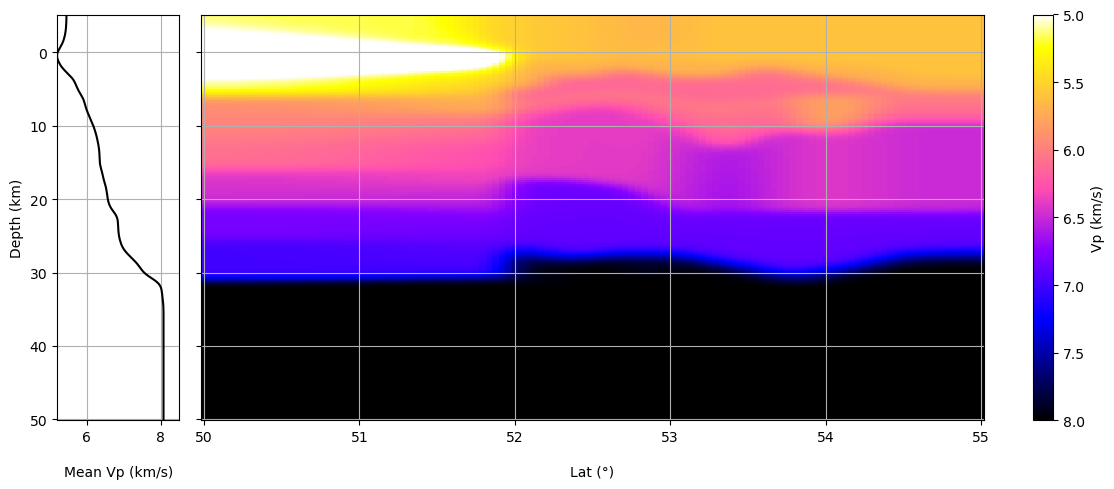

In [12]:
def plot_velocity_section(ncfile, mode="lon", value=None, cmap="jet", title=None):
    """
    Plot a vertical velocity section at constant latitude or longitude.

    Parameters:
        ncfile (str): Path to NetCDF file with 'vp(z, lat, lon)'.
        mode (str): 'lon' (default) for lat–depth section, or 'lat' for lon–depth section.
        value (float): The lon or lat value where to slice.
        cmap (str): GMT colormap name.
        title (str): Optional title for the plot.

    Example:
        plot_velocity_section("vp_3d_rbf.nc", mode="lon", value=-9.0)
    """
    #ds = xr.open_dataset(ncfile)
    #ds=ds_3d
    vp = ds["vp"].transpose("z", "lat", "lon").values
    lat = ds["lat"].values
    lon = ds["lon"].values
    z = ds["z"].values

    # Determine slice
    if mode == "lon":
        if value is None:
            value = lon[len(lon)//2]
        ix = np.abs(lon - value).argmin()
        vp_slice = vp[:, :, ix]  # shape: (z, lat)
        coords = {"z": z, "lat": lat}
        dims = ("z", "lat")
        region = [lat.min(), lat.max(), z.min(), z.max()]
        xlabel = "Latitude"
    elif mode == "lat":
        print("lat")
        if value is None:
            value = lat[len(lat)//2]
        iy = np.abs(lat - value).argmin()
        vp_slice = vp[:, iy, :]  # shape: (z, lon)
        coords = {"z": z, "lon": lon}
        dims = ("z", "lon")
        region = [lon.min(), lon.max(), z.min(), z.max()]
        xlabel = "Longitude"
    else:
        raise ValueError("mode must be 'lon' or 'lat'")

    # Temporary NetCDF for PyGMT
    section_ds = xr.Dataset({"vp": (dims, vp_slice)}, coords=coords)
    section_file = "vp_section.nc"
    section_ds.to_netcdf(folder + section_file)
    
    # Compute 1D velocity average at each depth
    vp_mean = np.nanmean(section_ds["vp"].values, axis=1)  # mean along the horizontal axis (lat or lon)

    # --- PLOTTING ---
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), gridspec_kw={"width_ratios": [1, 8]}, sharey=True)
    # Add 1D velocity average on right
    ax1.plot(vp_mean, section_ds["z"].values, color="black", linewidth=1.5, label="Mean Vp")
    ax2.invert_yaxis()
    ax1.set_ylabel("Depth (km)")
    ax1.set_xlim(min(vp_mean), 8.5)  # Adjust if needed
    ax1.set_xlabel("Mean Vp (km/s)", labelpad=15)
    ax1.grid(True)
    
    # Cross-section plot (2D)
    img = ax2.pcolormesh(section_ds["lat"] if "lat" in section_ds.dims else section_ds["lon"], section_ds["z"], section_ds["vp"], shading="auto", cmap='gnuplot2_r', vmin=5.0, vmax=8.0)
    ax2.set_xlabel("Lat (°)" if "lat" in section_ds.dims else "Lon (°)", labelpad=15)
    ax2.grid(True)
    # Colorbar (attached to 2D plot)
    cbar = plt.colorbar(img, ax=ax2, label="Vp (km/s)")
    cbar.ax.invert_yaxis()

    plt.tight_layout()
    plt.show()
    
# --- Choose a fixed longitude for the section ---
#vp_grd = "/home/bmelo/bin/SeisBlast/1D_velocity/3D-model/vp_3d_rbf.nc"
plot_velocity_section(ds_3d, mode="lon", value=-8)

In [13]:
ds = ds_3d  # drop empty depth levels
# --- Load NetCDF velocity model ---
#ds = xr.open_dataset("vp_3d_rbf.nc")  # adjust path
vp = ds["vp"].transpose("z", "lat", "lon").values
lat = ds["lat"].values
lon = ds["lon"].values
z   = ds["z"].values

# --- Create a 3D grid for the land mask ---
# Define Ngrid based on the shapes of lon, lat, and z
Ngrid = n_rtp

# Create custom ASCII file in the format lon, lat, dep, velocity
with open(folder + "vp_3d_full.txt", "w") as f:
    for k in range(Ngrid[2]):
        for j in range(Ngrid[1]):
            for i in range(Ngrid[0]):
                if not np.isnan(vp[k, j, i]):  # Only include non-NaN values
                    f.write(f"{lon[i]} {lat[j]} {z[k]} {vp[k, j, i]}\n")
